In [1]:
import numpy as np
import matplotlib.pyplot as plt

data_orginal = np.genfromtxt('bullionist_controversy_full.csv',
                             delimiter=',',
                             skip_header=1)
# col1 = year
# col2 = industrial production
# col3 = cpi

In [2]:
# Growth rates
log1 = np.log(data_orginal[1:,1:])
log2 = np.log(data_orginal[:-1,1:])
data = log1.transpose() - log2.transpose()

# y1 = ip
# y2 = cpi

In [3]:
# Parameters
p = 6 # VAR(6)
const = 1 # constant (yes/no)
h = 30 # forecast horizon
n = np.size(data,0) # No. of variables
N = np.size(data,1) # No. of observations

In [4]:
np.zeros((n*p,N-p)).shape

(12, 207)

In [27]:
# OLS estimation (Y=A*Z+U)
def VAROLS(data,p,const):
    n = np.size(data,0) # No. of variables
    N = np.size(data,1) # No. of observations
    Y = data[:,p:]
    Z = np.zeros([n*p,N-p])
    for jj in np.arange(N-p):
        Z[:,jj]= np.reshape(np.fliplr(data[:, jj:jj+p]),
                            n*p,order='F')
    Z = np.concatenate((np.ones((const,N-p)),Z),axis=0)
    
    # A=(Y*Y')*inv(Z*Z')
    A = np.dot(np.dot(Y,Z.T),
               np.linalg.inv(np.dot(Z,Z.T)))
    
    Sigma = (np.dot(Y,Y.T) - np.dot(A, np.dot(Z,Y.T)))/(N-n*p-const)
    return A, Sigma

A, Sigma = VAROLS(data,p,const)

A

array([[ 0.02466454, -0.17977756, -0.16013986, -0.18509617, -0.01227251,
        -0.02087178, -0.07163293,  0.02140098, -0.12846598,  0.01650084,
        -0.00710219,  0.02152358, -0.00674877],
       [ 0.00370338,  0.0035608 ,  0.13153262,  0.20809894, -0.20068946,
        -0.14965395, -0.1375212 , -0.23048195, -0.16545404, -0.10435213,
         0.09269145,  0.07190221, -0.06164289]])

In [28]:
# VAR(1) representation: Selection (Xi) and companion matrix (J)
def VAR1(A,p,const):
    n = np.size(data,0) # No. of variables
    A = A[:, const:]
    
    eye = np.eye(n*(p-1))
    zeros = np.zeros((n*(p-1),n))
    mat = np.concatenate((eye,zeros),axis=1)
    
    Xi = np.concatenate((A,mat),axis=0)
    
    J = np.concatenate((np.eye(n),
                        np.zeros((n,n*(p-1)))),
                       axis=1)
    return Xi, J

Xi, J = VAR1(A,p,const)

Xi

array([[-0.17977756, -0.16013986, -0.18509617, -0.01227251, -0.02087178,
        -0.07163293,  0.02140098, -0.12846598,  0.01650084, -0.00710219,
         0.02152358, -0.00674877],
       [ 0.0035608 ,  0.13153262,  0.20809894, -0.20068946, -0.14965395,
        -0.1375212 , -0.23048195, -0.16545404, -0.10435213,  0.09269145,
         0.07190221, -0.06164289],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  

In [29]:
# Solve identification problem: Blanchard-Quah decomposition
def BlanchardQuach(Xi,J,Sigma):
    # Reduced form long-run multiplier
    B1 = np.dot(np.dot(J,np.linalg.inv(np.identity(n*p)-Xi)),J.T)
    # Structural long-run multiplier
    temp = np.dot(np.dot(B1,Sigma),B1.T)
    # Impact matrix
    C1 = np.linalg.cholesky(temp)
    S = np.dot(np.linalg.inv(B1),C1)
    return S, C1

S, C1 = BlanchardQuach(Xi,J,Sigma)

S, C1

(array([[ 0.03921559,  0.01623303],
        [-0.02436728,  0.05634571]]),
 array([[ 0.03645104,  0.        ],
        [-0.02363107,  0.04201507]]))

In [33]:
# Impulse responses
epsilon = np.eye(n)
C = np.zeros((h+1,n,n))

for jj in np.arange(h+1):
    temp1 = np.dot(J, np.linalg.matrix_power(Xi,jj))
    temp2 = np.dot(temp1,J.T)
    temp3 = np.dot(temp2, S)
    C[jj:,:,:] = np.dot(temp3,epsilon)
    
Cs = np.cumsum(C,axis=0)

array([[ 3.64504264e-02, -2.23738443e-06],
       [-2.36327213e-02,  4.20061057e-02]])

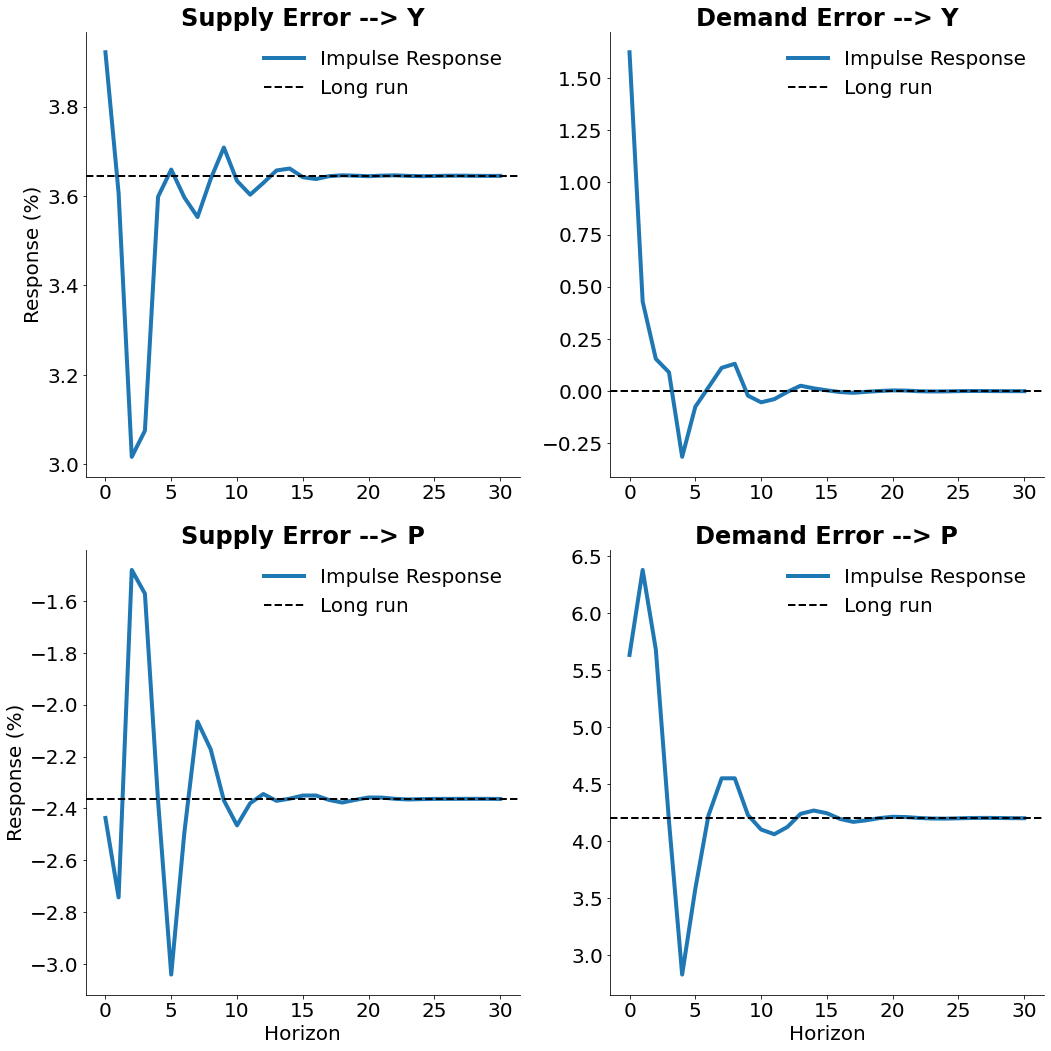

In [9]:
# Plots of impulse responses
horizon = np.arange(0,h+1)

Cs1 = 100*Cs[:,0,0]
Cs2 = 100*Cs[:,0,1]
Cs3 = 100*Cs[:,1,0]
Cs4 = 100*Cs[:,1,1]

shocks = ['Supply Error','Demand Error']
# shocks = [r'$\mathrm{\epsilon_S}','Demand Error']
response = ['Y','P']

plt.rcParams.update({'font.size': 20}) 
fig, ax = plt.subplots(2,2,figsize=(15,15))

ax[0,0].plot(horizon,Cs1,lw='4')
ax[0,0].axhline(y=100*C1[0,0],c='k',lw='2',ls='--')

ax[0,1].plot(horizon,Cs2,lw='4')
ax[0,1].axhline(y=100*C1[0,1],c='k',lw='2',ls='--')

ax[1,0].plot(horizon,Cs3,lw='4')
ax[1,0].axhline(y=100*C1[1,0],c='k',lw='2',ls='--')

ax[1,1].plot(horizon,Cs4,lw='4')
ax[1,1].axhline(y=100*C1[1,1],c='k',lw='2',ls='--')

for i in np.arange(2):
    
    ax[1,i].set_xlabel('Horizon')
    ax[i,0].set_ylabel('Response (%)')
    
    for j in np.arange(2):
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].set_title(shocks[j] + ' --> ' + response[i]
                          ,fontweight='bold')
        ax[i,j].legend(['Impulse Response','Long run'],
                       frameon=False,loc='best')

plt.tight_layout()

In [10]:
# Forcast Error Variance Decomposition
theta = np.zeros((h+1,n,n))
theta[0,:,:] = Cs[0,:,:]**2 /np.tile(
    (Cs[0,:,:]**2).sum(axis=1).reshape(n,1),
    (1,n))

for jj in np.arange(h):
    # numerator
    temp1 = (Cs[:jj+2,:,:] ** 2).sum(axis=0)
    # denominator
    temp2 = np.transpose((Cs[:jj+2,:,:] ** 2).sum(axis=2)) # forecast error variance for each h
    temp3 = np.transpose(np.array([temp2.sum(axis=1)]))
    temp4 = np.tile(temp3,(1,n))
    # result
    theta[jj+1,:,:] = temp1 / temp4
    
FEVD_long = C1

In [25]:
(Cs[:2,:,:] ** 2).sum(axis=2)

array([[0.00180137, 0.0037686 ],
       [0.00131929, 0.00482489]])